In [1]:
import collections
collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
# load dataset
dataset = Dataset(dataset_dir="../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/dataset/", augmentation=get_training_augmentation())

D:\anaconda\envs\segmentation_gpu\lib\site-packages\albumentations\augmentations\transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


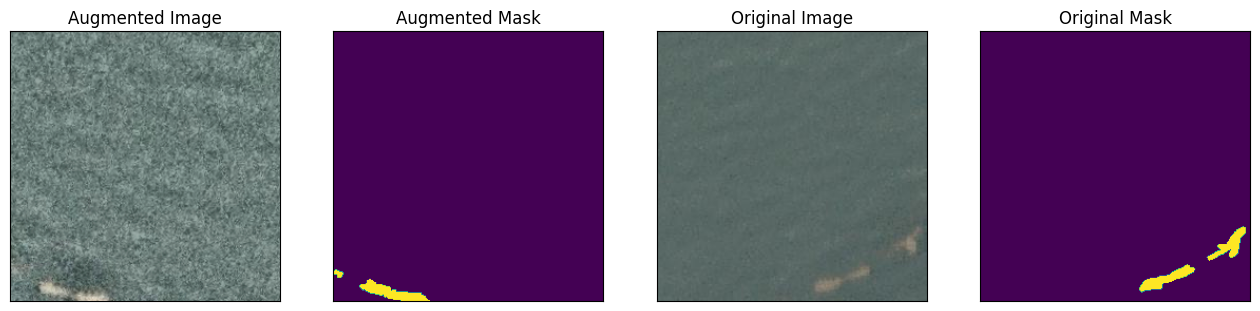

In [6]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

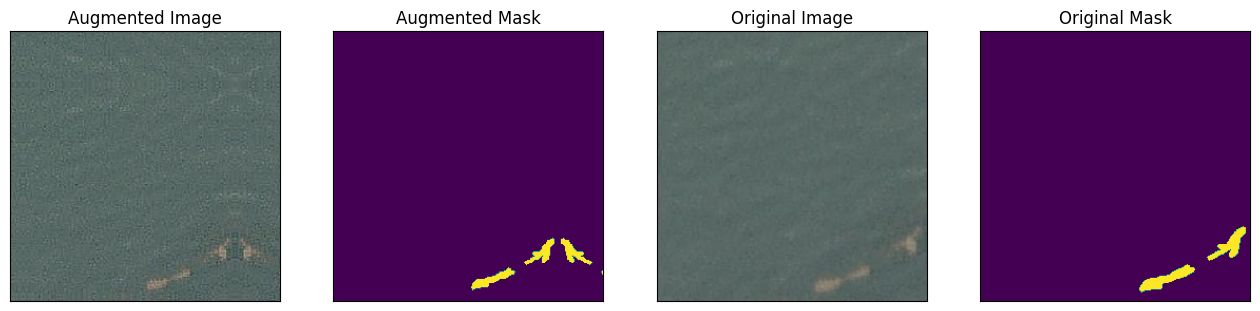

In [7]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

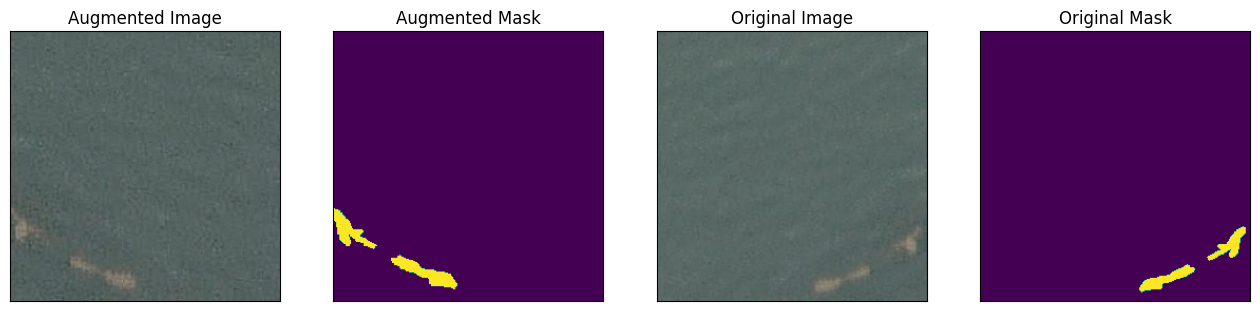

In [8]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

In [9]:
with tf.device('/GPU:0'):
    # train test split
    x_train, x_val, y_train, y_val = dataset.split_data()

    # pre processing
    x_train, y_train, x_val, y_val = dataset.pre_process(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

    # define dataloader and datasets objects for train and validation data
    train_dataset = Dataset(
        x=x_train,
        y=y_train,
        augmentation=get_training_augmentation()
    )

    valid_dataset = Dataset(
        x=x_val,
        y=y_val,
        augmentation=get_training_augmentation()
    )

In [10]:
train_dataloader = Dataloader(train_dataset, batch_size=8, shuffle=True, generate=20)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False, generate=10)

In [11]:
with tf.device('/GPU:0'):
    BACKBONE = 'resnet50'
    BATCH_SIZE = 8
    EPOCHS = 25

    preprocess_input = sm.get_preprocessing(BACKBONE)
    # define network parameters
    n_classes = 1
    activation = 'sigmoid'

    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    # dice loss = 1 - (2 * intersection) / (union + intersection)
    dice_loss = sm.losses.DiceLoss()
    # Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
    # α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
    # p is the predicted probability of the positive class.
    # γ is the focusing parameter that controls how much the loss is focused on hard examples.
    # When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
    # the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
    focal_loss = sm.losses.BinaryFocalLoss(gamma=2.5, alpha=0.3)

    total_loss = dice_loss + 1.5*focal_loss

    metrics = [sm.metrics.IOUScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
    # define callbacks for learning rate scheduling and best checkpoints saving
    callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model_resnet50_1.h5', save_weights_only=True, save_best_only=True, mode='min', monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(),
    ]
    tf.config.run_functions_eagerly(True)
    history = model.fit(
    x=train_dataloader.dataset.x,
    y=train_dataloader.dataset.y,
    shuffle=train_dataloader.shuffle,
    batch_size=train_dataloader.batch_size,
    callbacks=callbacks,
    epochs=EPOCHS,
    validation_data=(valid_dataloader.dataset.x, valid_dataloader.dataset.y),
    )

94592056/94592056 [==============================] - 7s 0us/step


C:\Users\AvivL\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
400/400 [==============================] - 107s 254ms/step - loss: 0.5876 - iou_score: 0.3744 - val_loss: 0.4444 - val_iou_score: 0.4417 - lr: 0.0010
Epoch 2/25
400/400 [==============================] - 102s 255ms/step - loss: 0.3718 - iou_score: 0.5023 - val_loss: 0.2453 - val_iou_score: 0.6468 - lr: 0.0010
Epoch 3/25
400/400 [==============================] - 101s 253ms/step - loss: 0.3082 - iou_score: 0.5679 - val_loss: 0.4588 - val_iou_score: 0.4639 - lr: 0.0010
Epoch 4/25
400/400 [==============================] - 100s 250ms/step - loss: 0.2649 - iou_score: 0.6164 - val_loss: 0.2831 - val_iou_score: 0.6020 - lr: 0.0010
Epoch 5/25
400/400 [==============================] - 100s 250ms/step - loss: 0.2513 - iou_score: 0.6325 - val_loss: 0.2302 - val_iou_score: 0.6628 - lr: 0.0010
Epoch 6/25
400/400 [==============================] - 107s 267ms/step - loss: 0.2280 - iou_score: 0.6605 - val_loss: 0.2421 - val_iou_score: 0.6510 - lr: 0.0010
Epoch 7/25
400/400 [==============

1/1 [==============================] - 1s 926ms/step


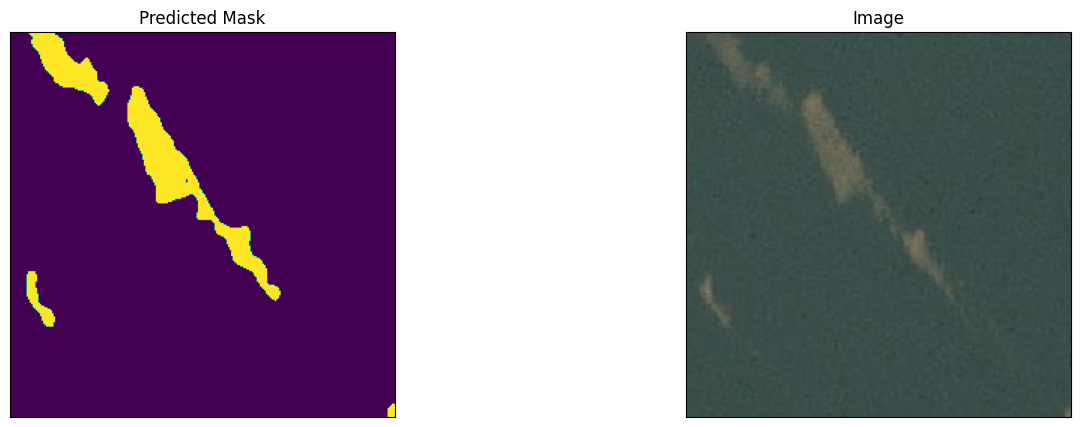

1/1 [==============================] - 0s 98ms/step


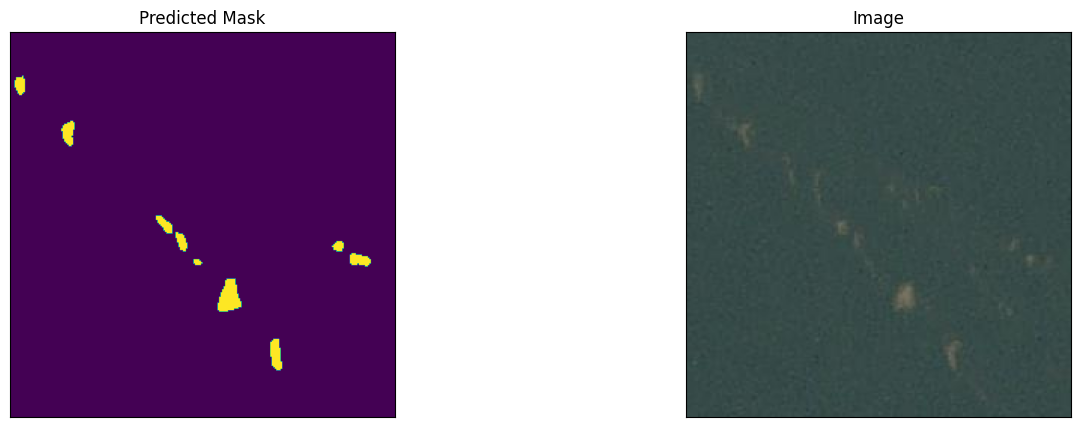

1/1 [==============================] - 0s 98ms/step


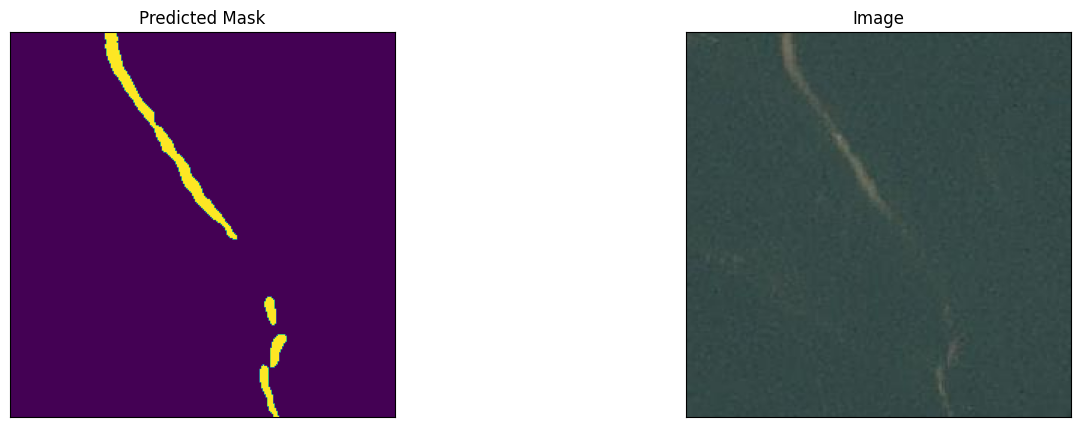

1/1 [==============================] - 0s 94ms/step


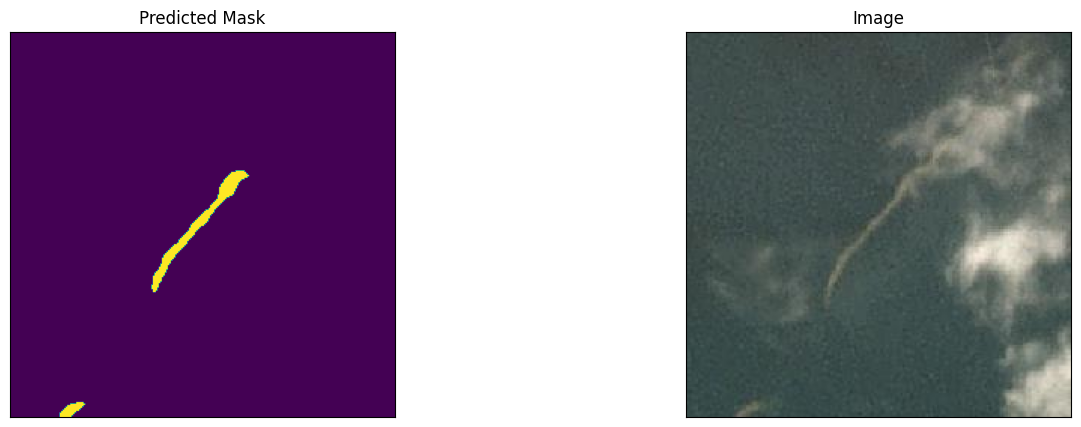

1/1 [==============================] - 0s 107ms/step


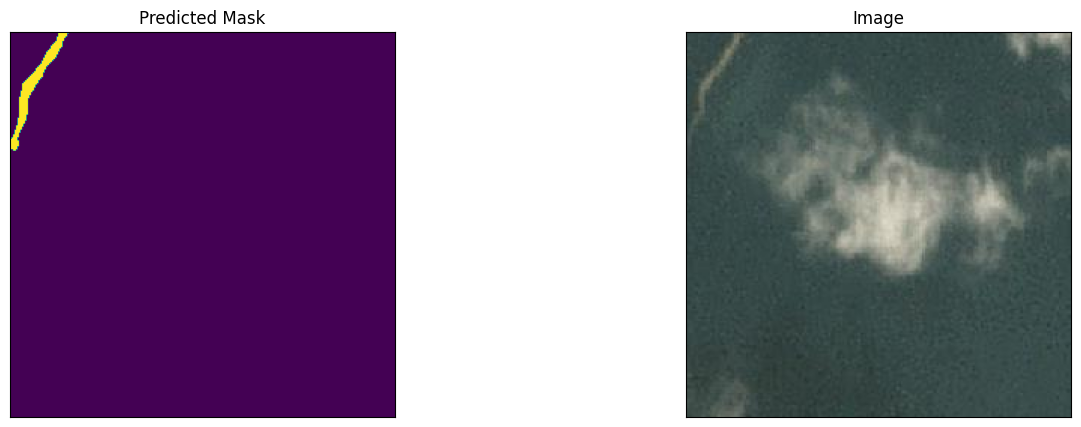

1/1 [==============================] - 0s 102ms/step


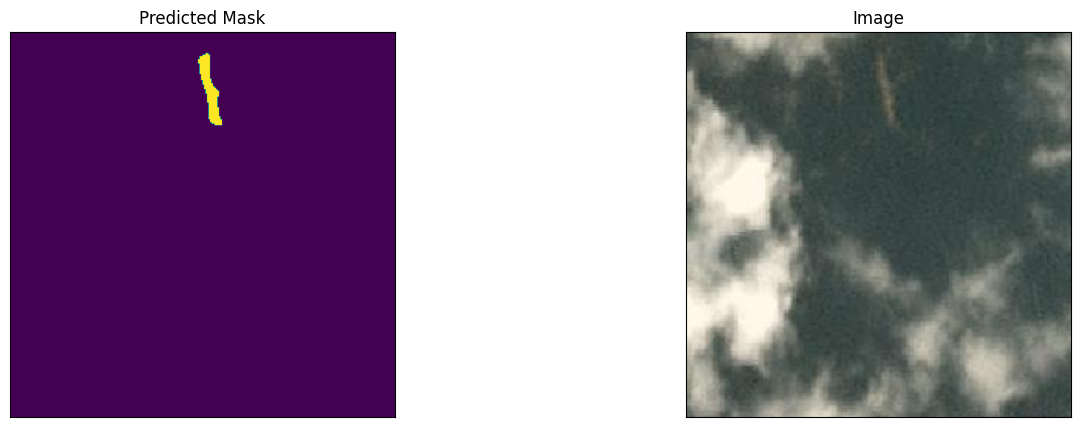

1/1 [==============================] - 0s 96ms/step


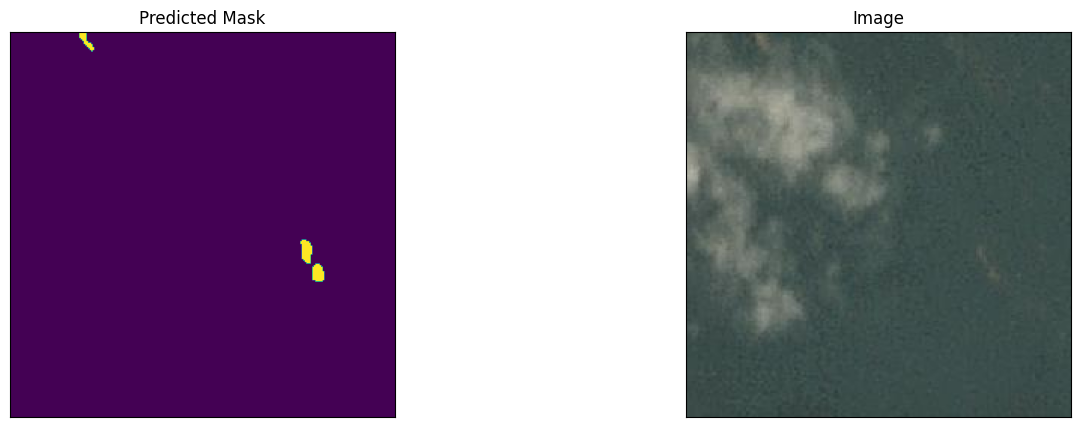

1/1 [==============================] - 0s 97ms/step


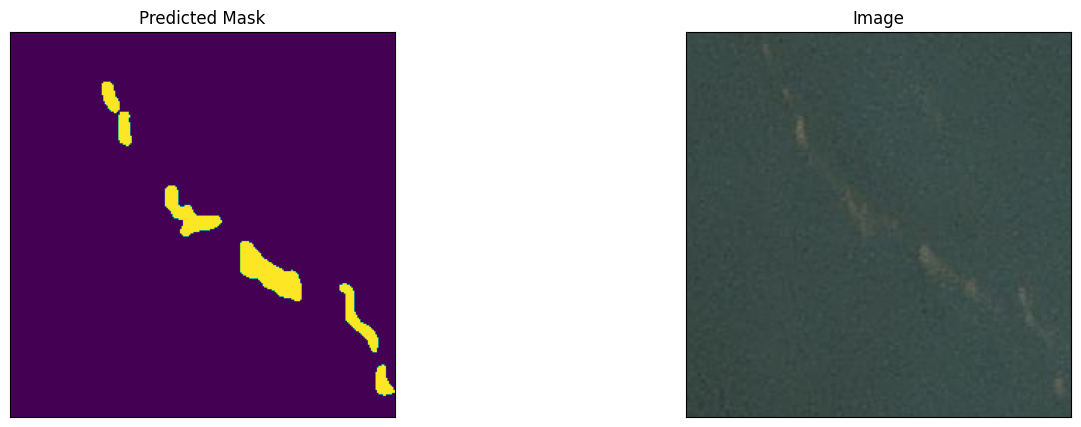

1/1 [==============================] - 0s 99ms/step


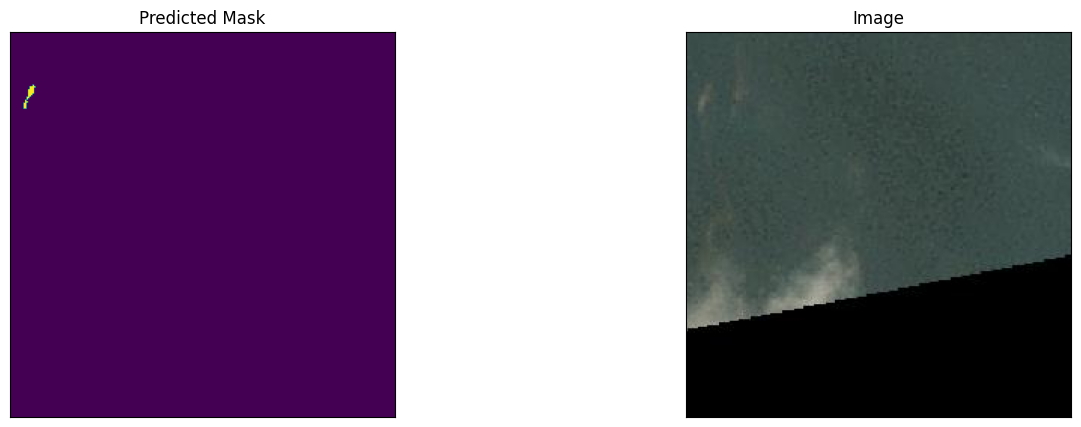

1/1 [==============================] - 0s 91ms/step


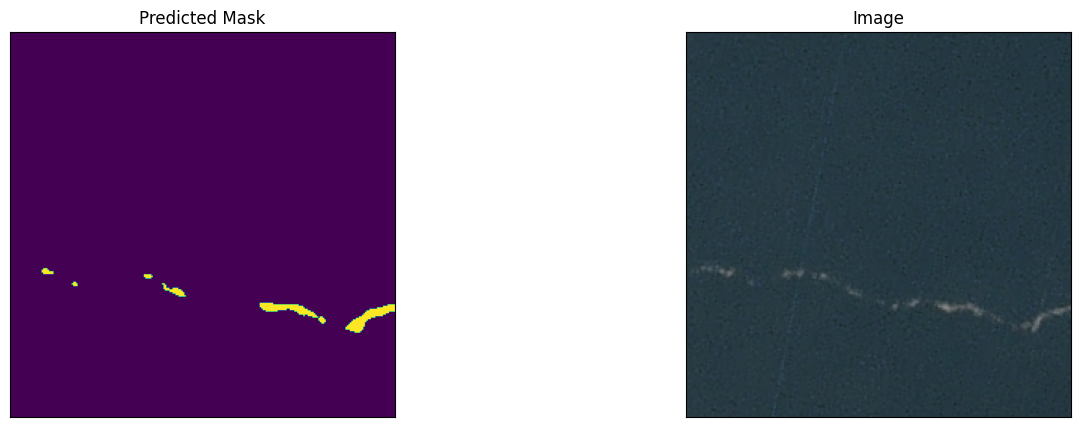

In [12]:
with tf.device("/GPU:0"):
    ## checking predictions on new unannotated images
    dataset_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/unannotated_images/"
    test_images = []
    for filename in os.listdir(dataset_dir):
        image_path = os.path.join(dataset_dir, filename)
        test_images.append(io.imread(image_path))

    for test_image in test_images:
        prediction = predict(model=model, image=test_image)
        visualize(
          predicted_mask=prediction,
          image=test_image
        )

1/1 [==============================] - 0s 104ms/step


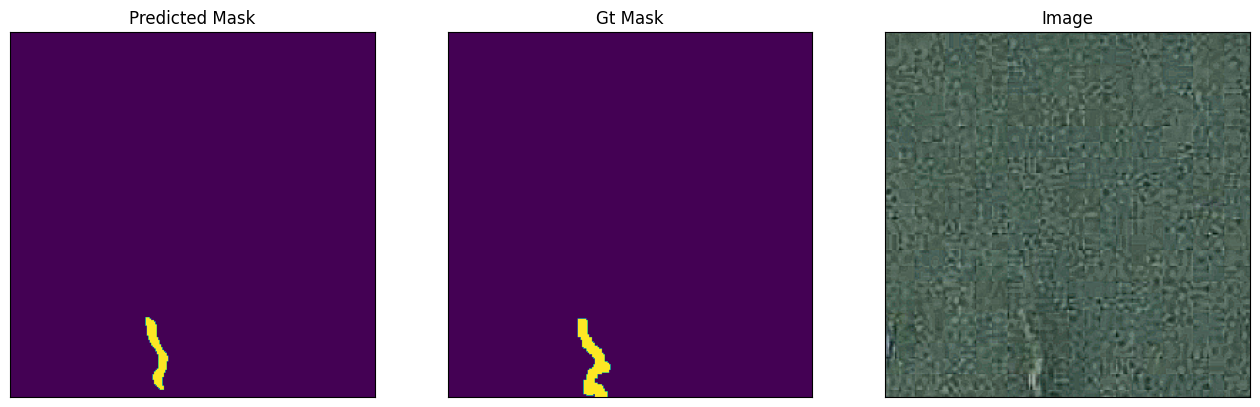

1/1 [==============================] - 0s 103ms/step


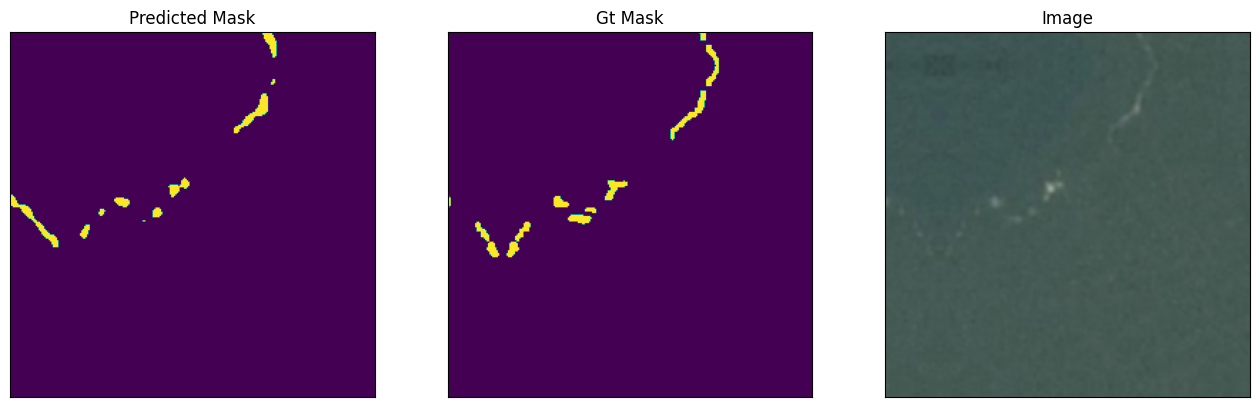

1/1 [==============================] - 0s 98ms/step


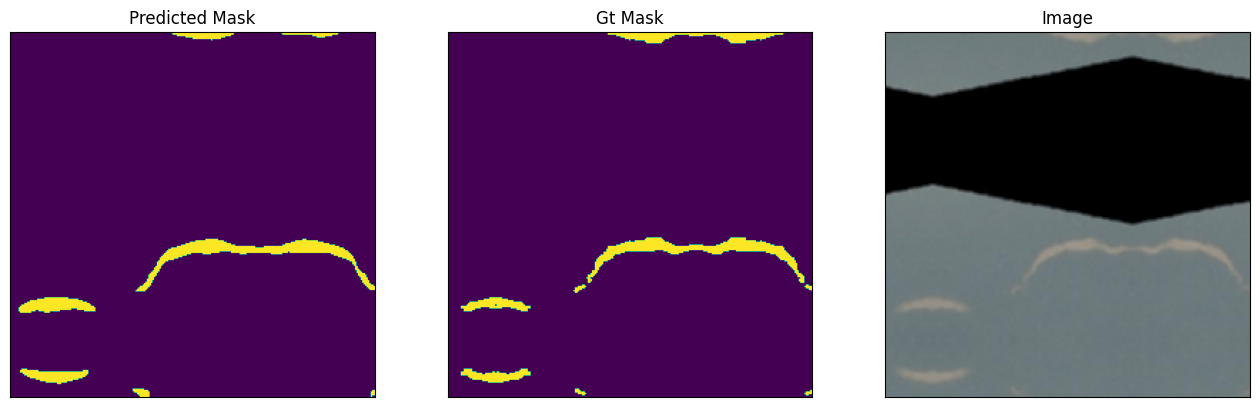

1/1 [==============================] - 0s 95ms/step


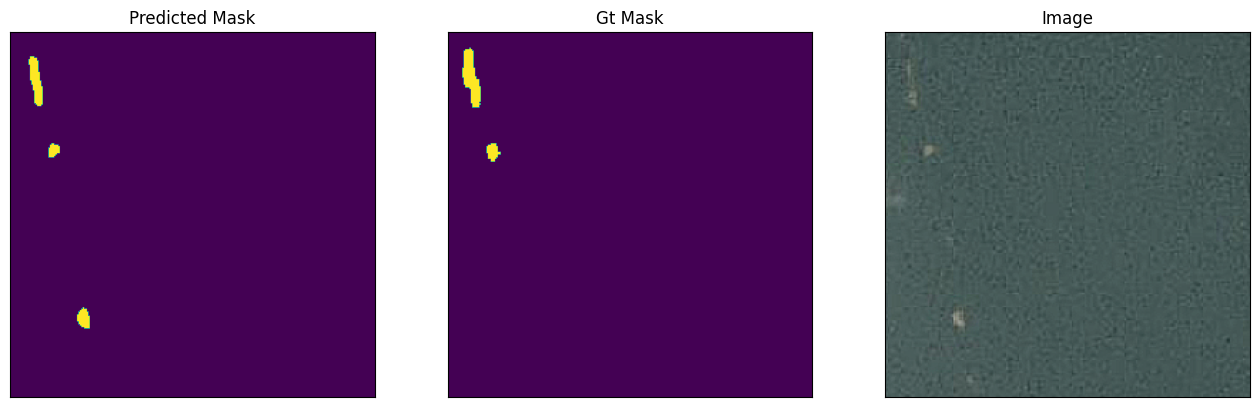

1/1 [==============================] - 0s 95ms/step


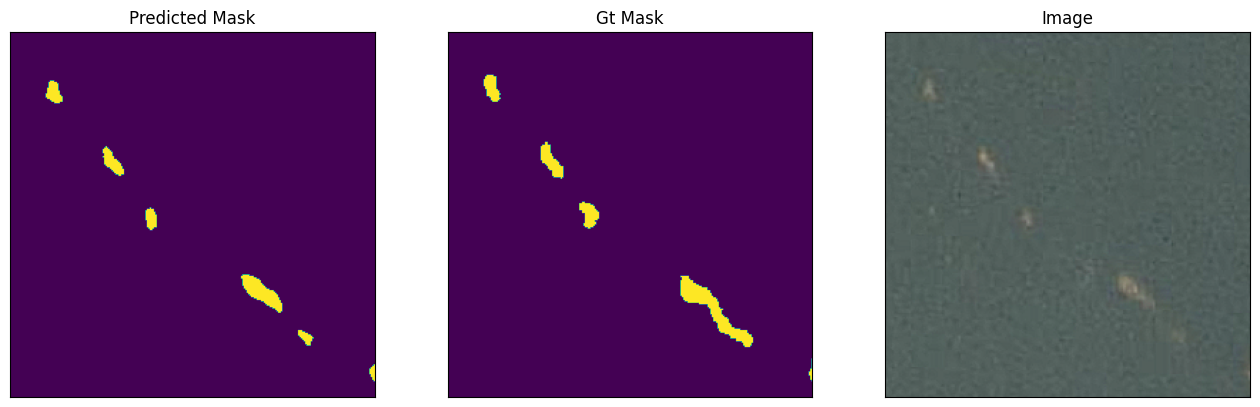

1/1 [==============================] - 0s 102ms/step


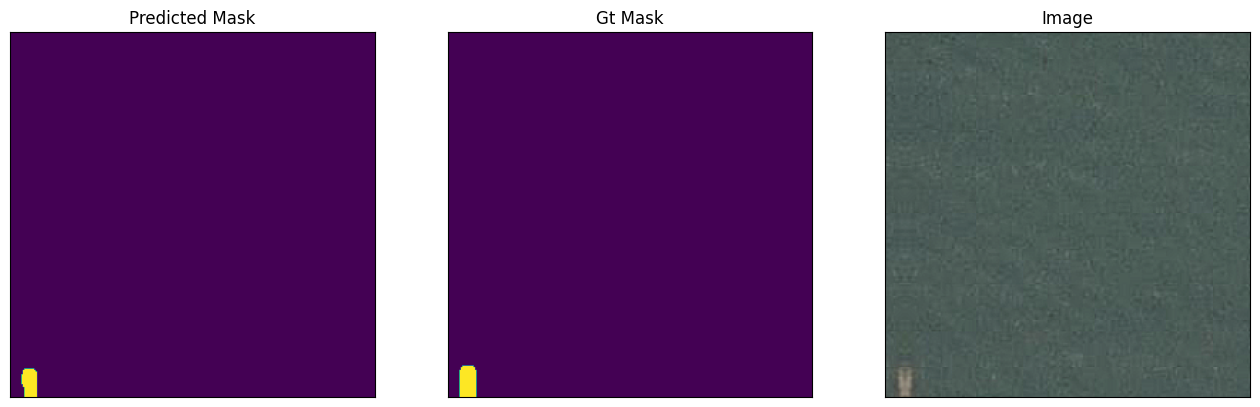

1/1 [==============================] - 0s 98ms/step


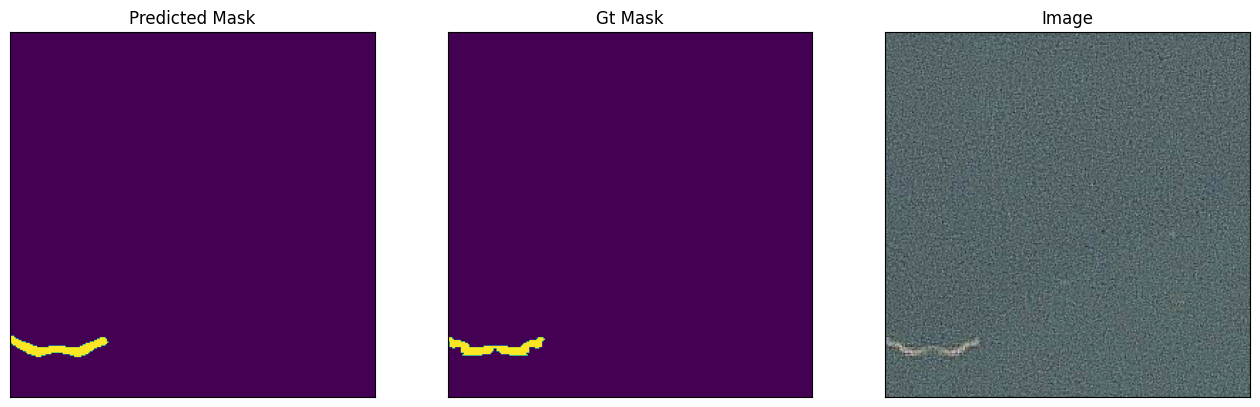

1/1 [==============================] - 0s 86ms/step


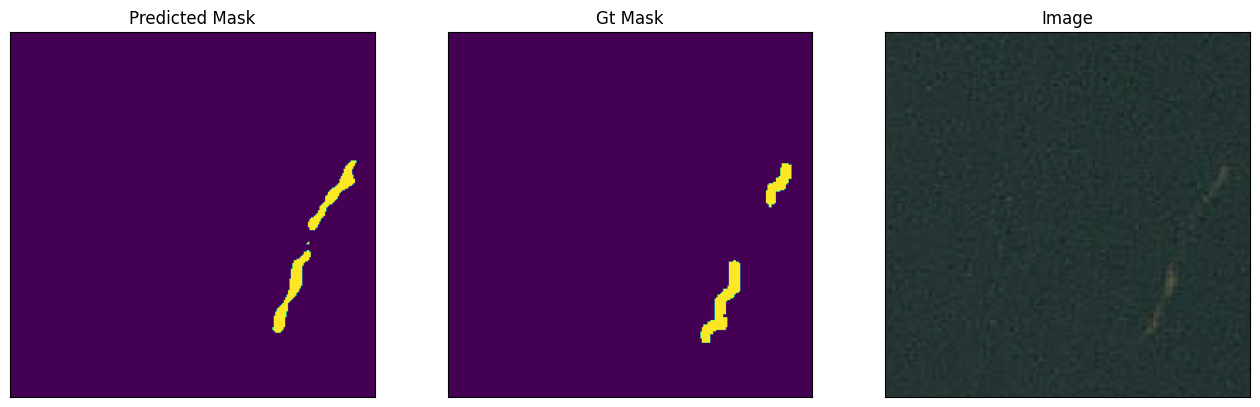

1/1 [==============================] - 0s 115ms/step


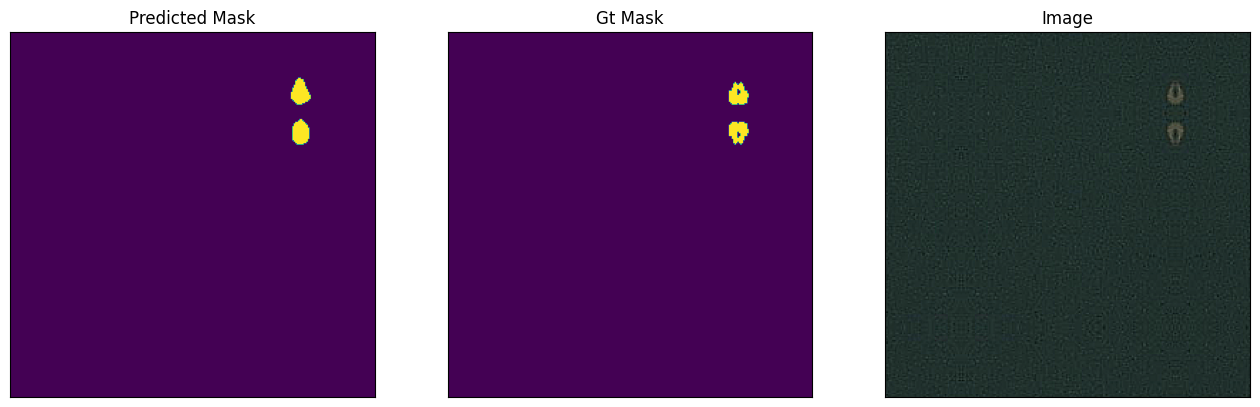

1/1 [==============================] - 0s 88ms/step


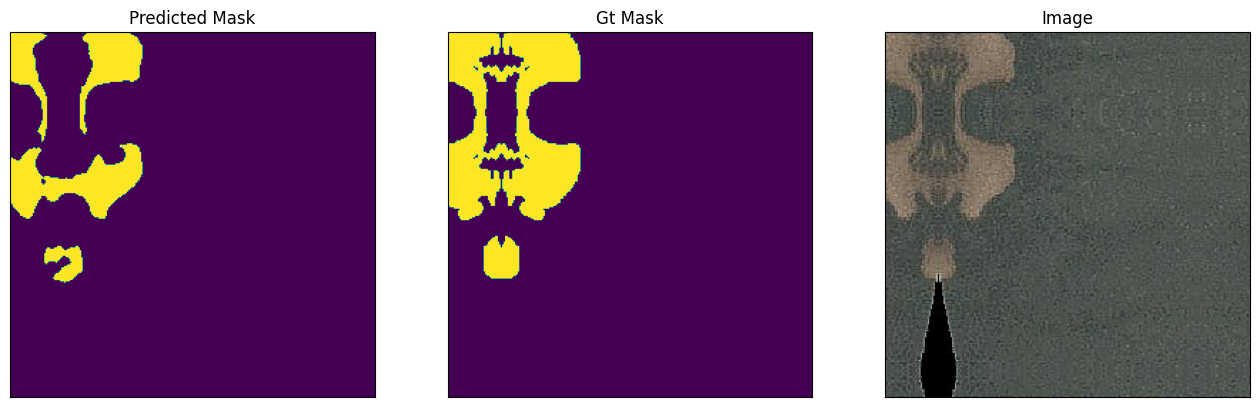

1/1 [==============================] - 0s 106ms/step


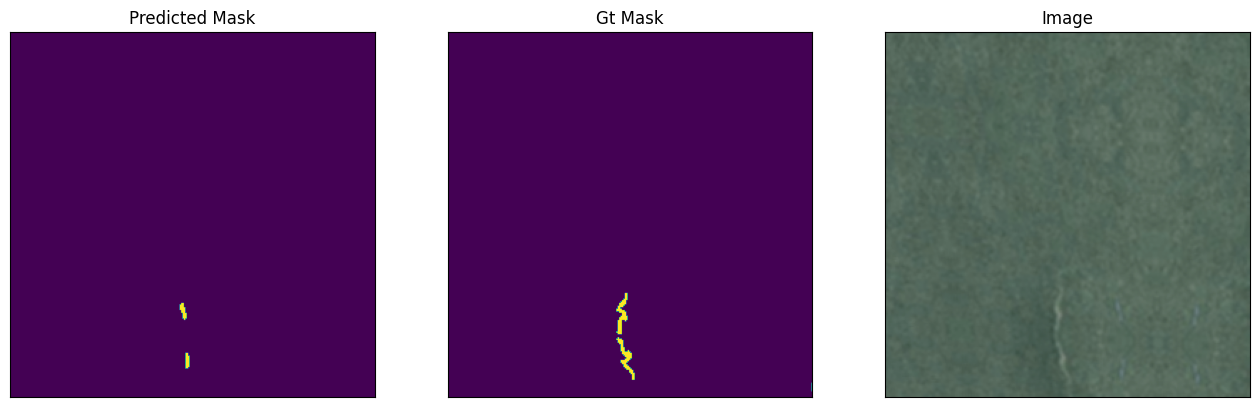

1/1 [==============================] - 0s 98ms/step


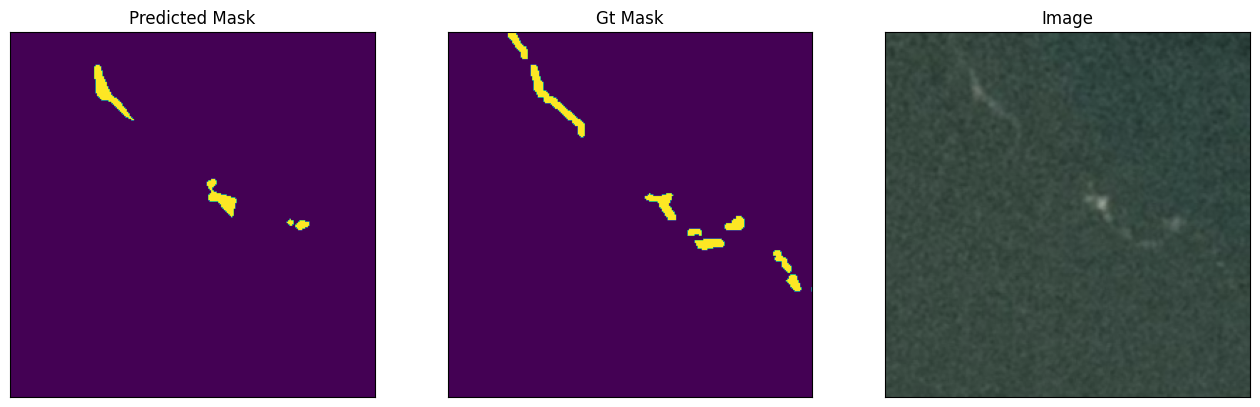

1/1 [==============================] - 0s 93ms/step


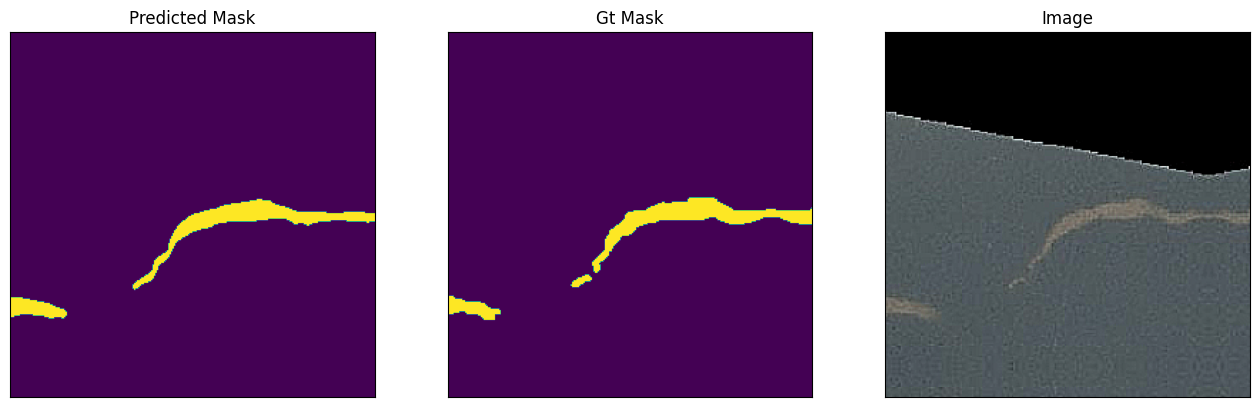

1/1 [==============================] - 0s 95ms/step


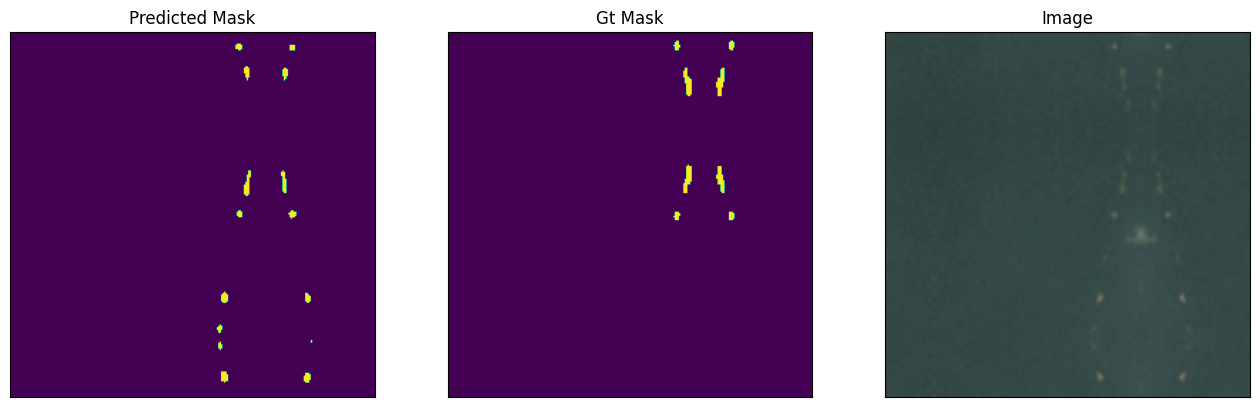

1/1 [==============================] - 0s 99ms/step


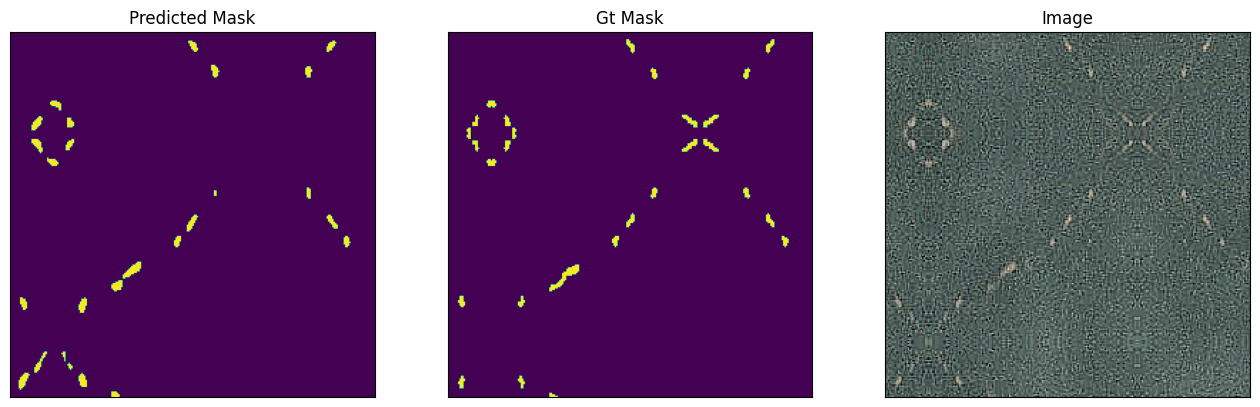

1/1 [==============================] - 0s 95ms/step


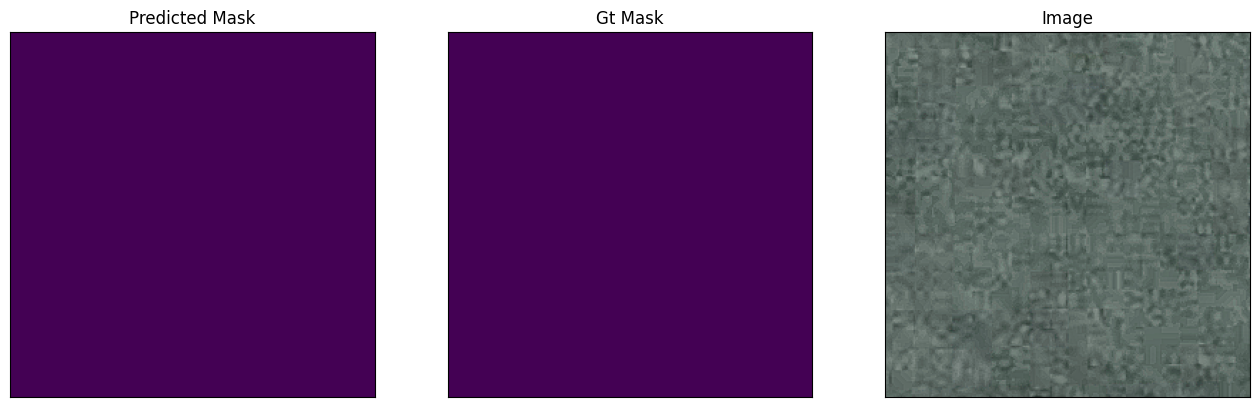

1/1 [==============================] - 0s 98ms/step


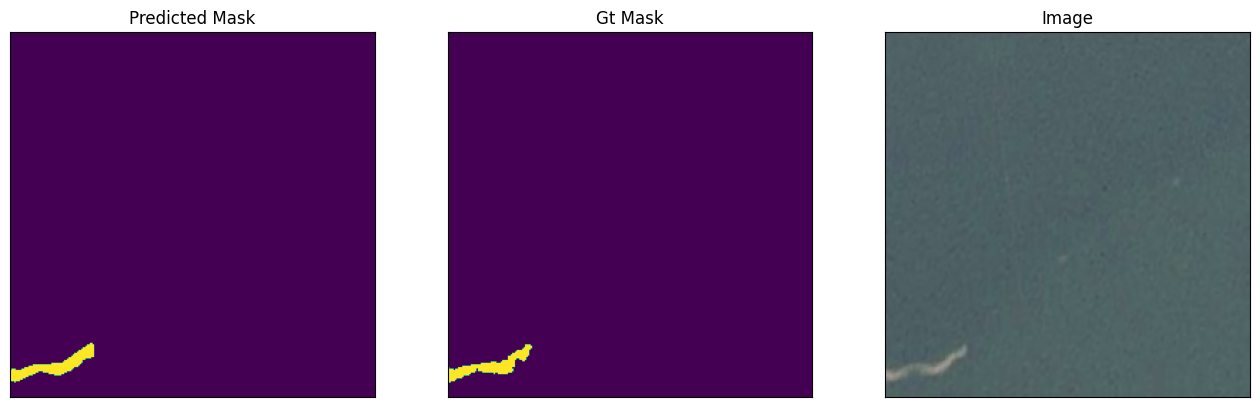

1/1 [==============================] - 0s 88ms/step


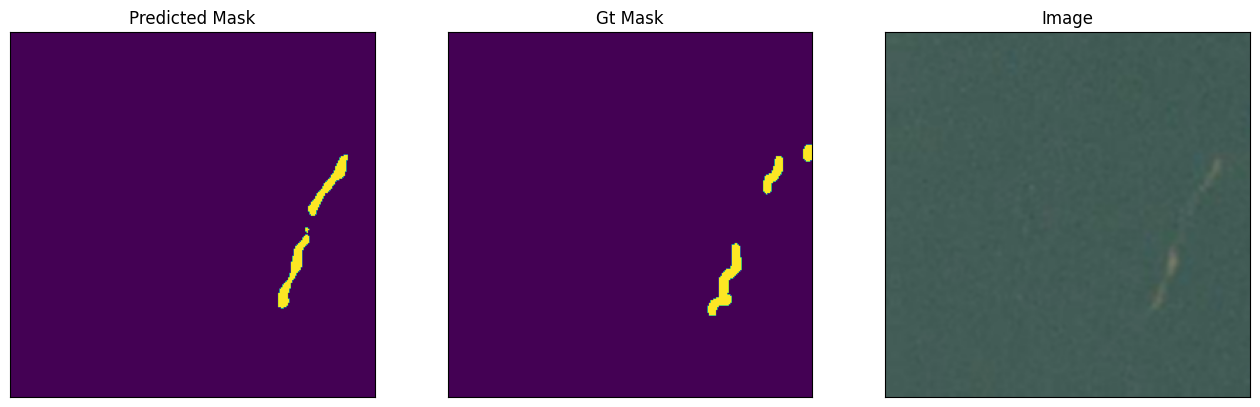

1/1 [==============================] - 0s 90ms/step


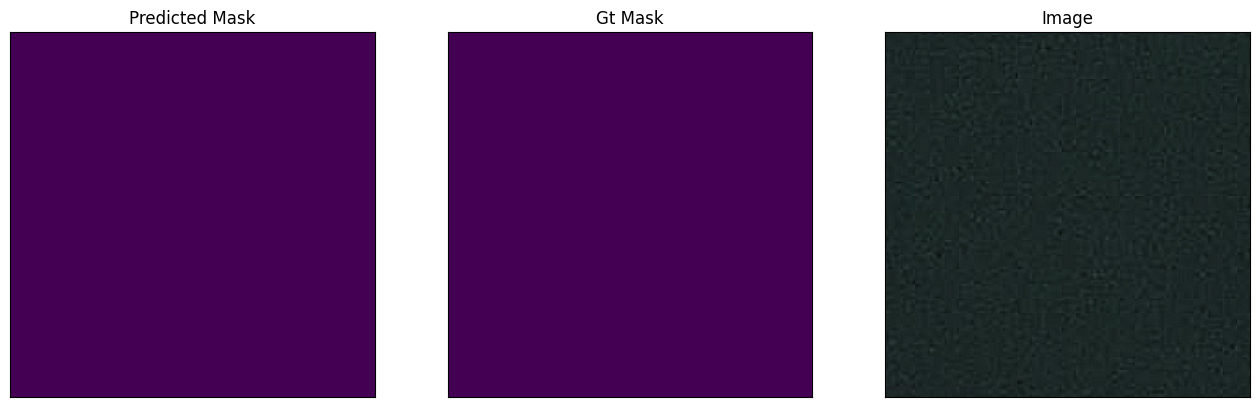

1/1 [==============================] - 0s 90ms/step


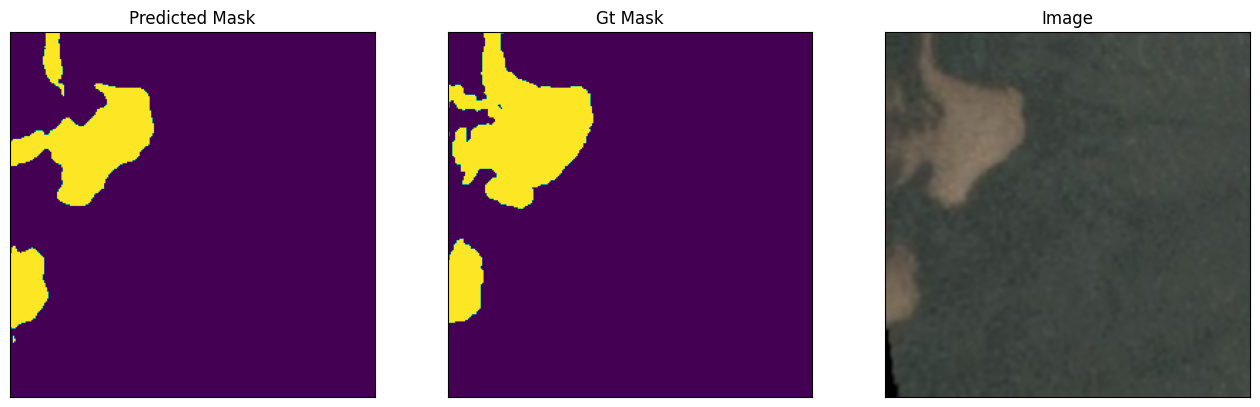

1/1 [==============================] - 0s 92ms/step


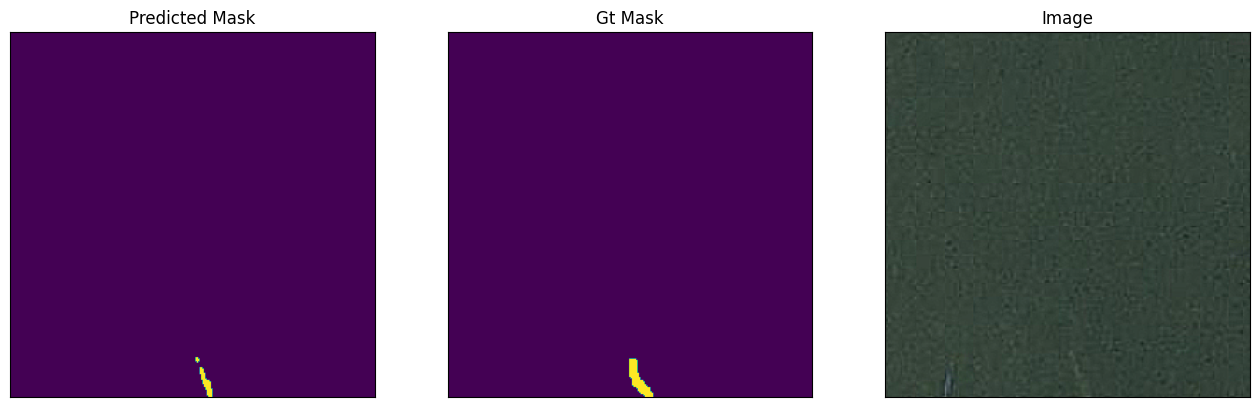

1/1 [==============================] - 0s 92ms/step


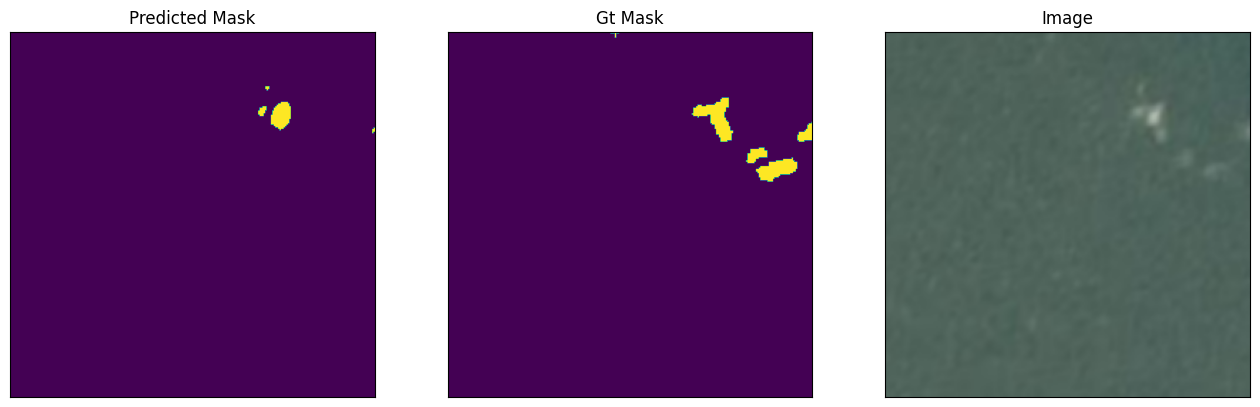

1/1 [==============================] - 0s 90ms/step


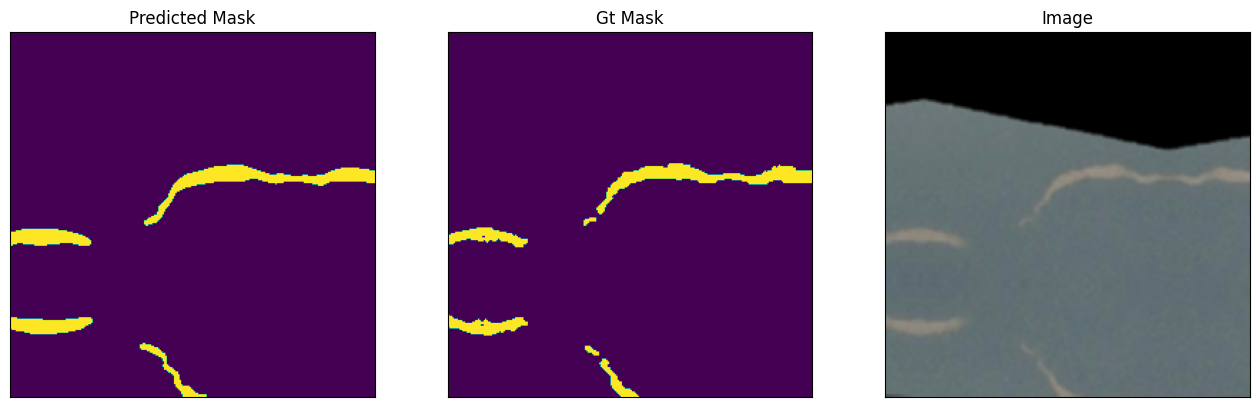

1/1 [==============================] - 0s 90ms/step


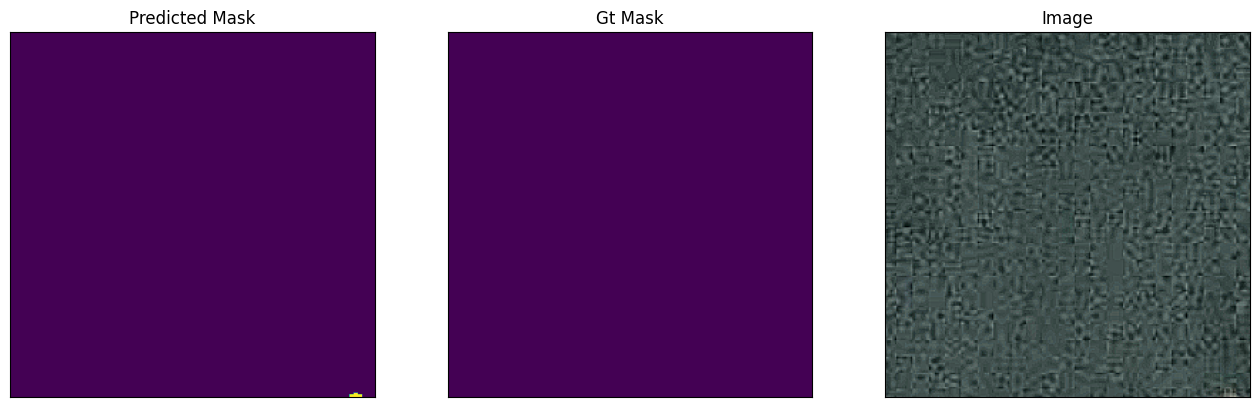

1/1 [==============================] - 0s 86ms/step


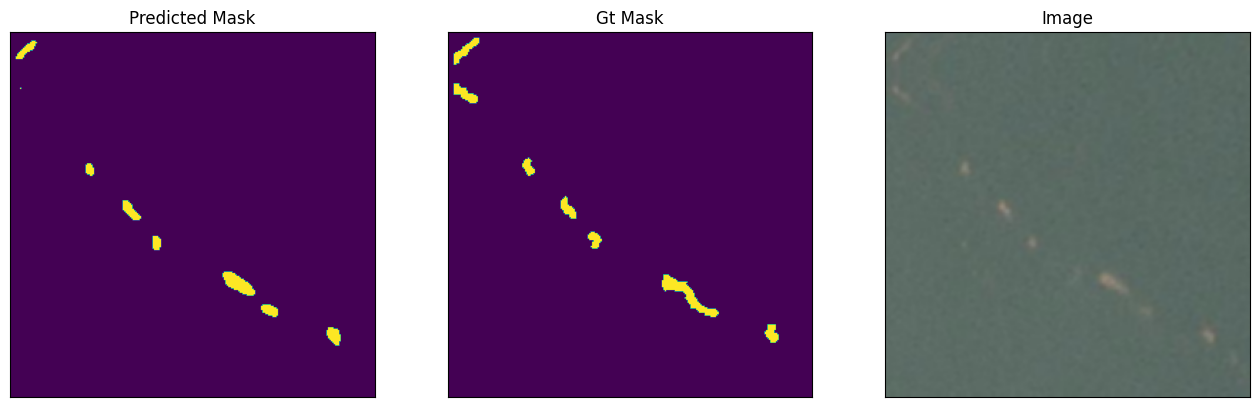

1/1 [==============================] - 0s 110ms/step


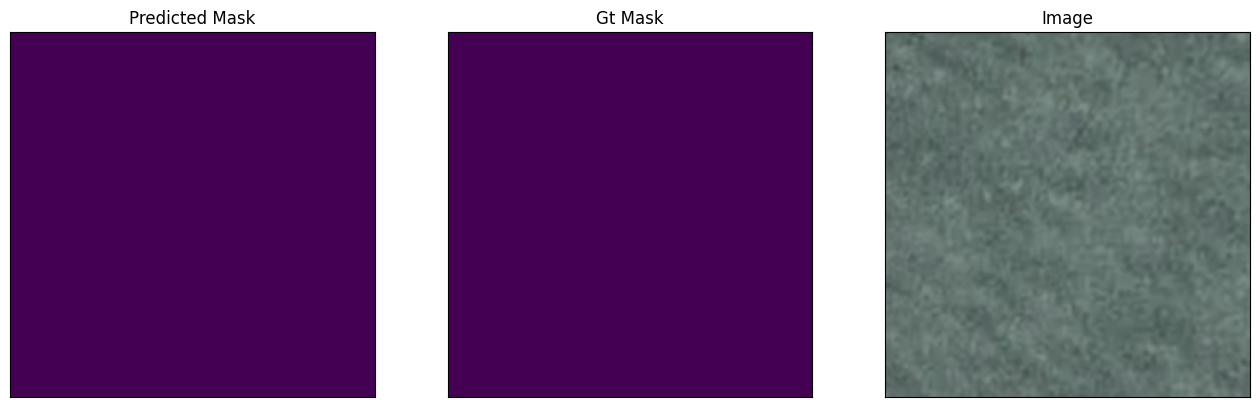

1/1 [==============================] - 0s 97ms/step


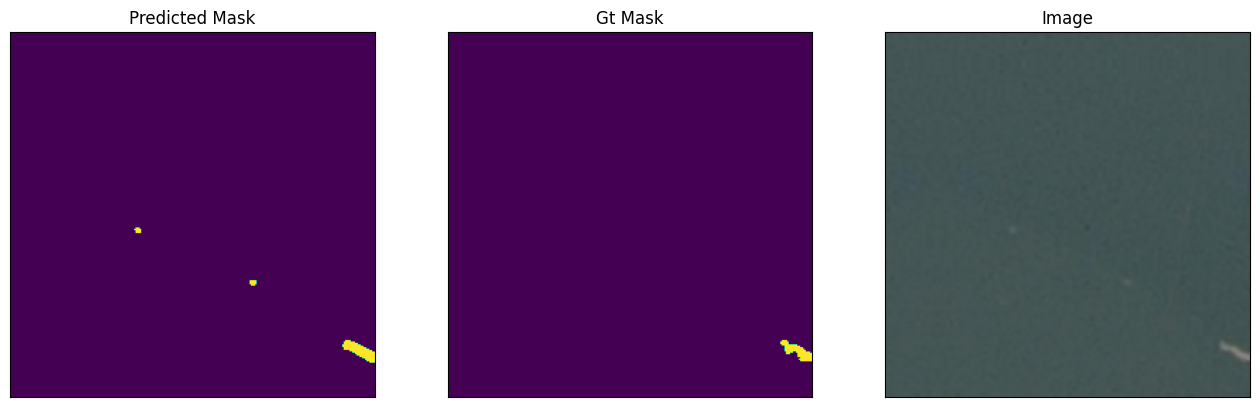

1/1 [==============================] - 0s 102ms/step


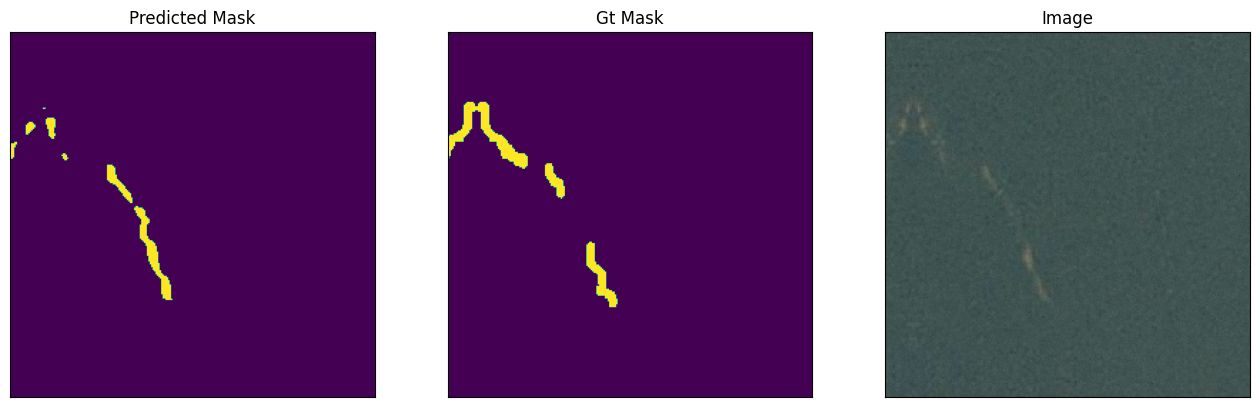

1/1 [==============================] - 0s 102ms/step


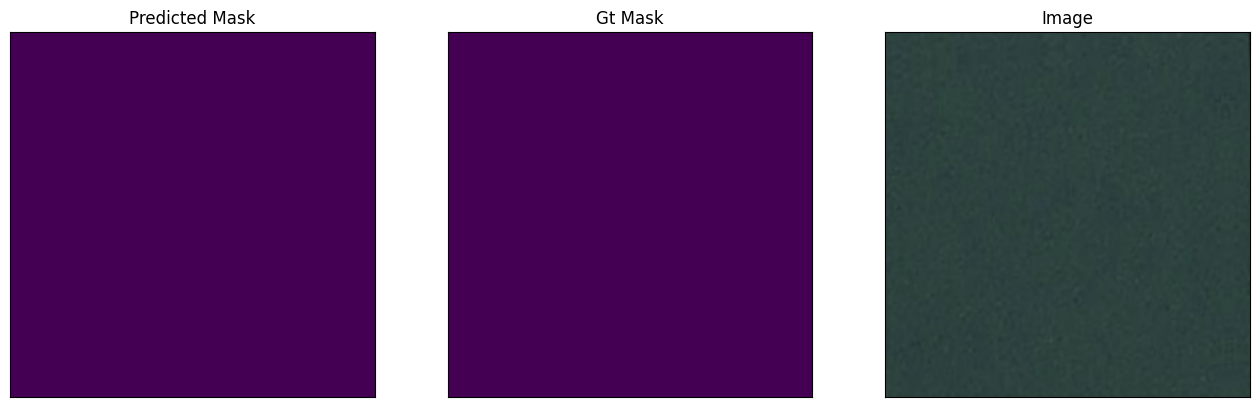

1/1 [==============================] - 0s 106ms/step


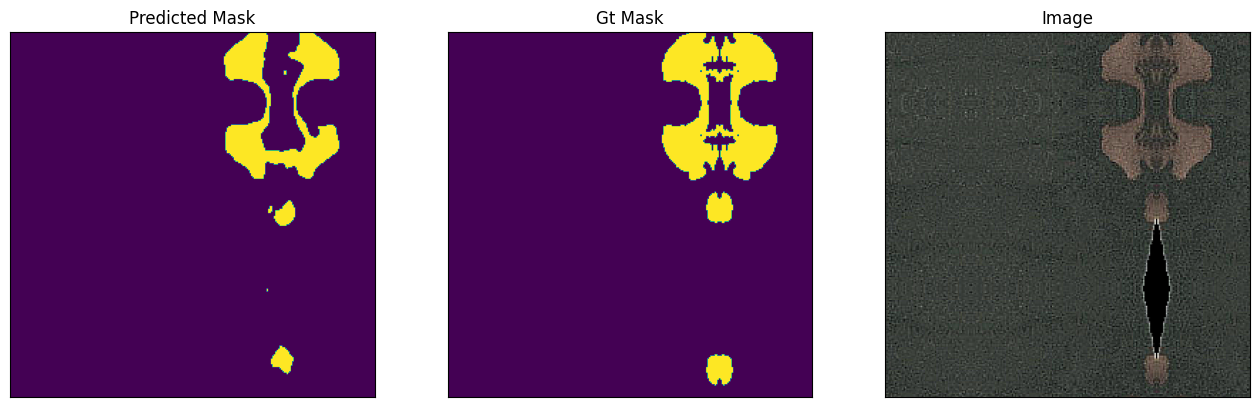

In [13]:
with tf.device('/GPU:0'):
    # checking few predictions from the valid dataset
    for i in range(20, 50):
      prediction = predict(model, valid_dataloader.dataset.x[i])
      visualize(
          predicted_mask=prediction,
          gt_mask=valid_dataloader.dataset.y[i],
          image=valid_dataloader.dataset.x[i]
      )

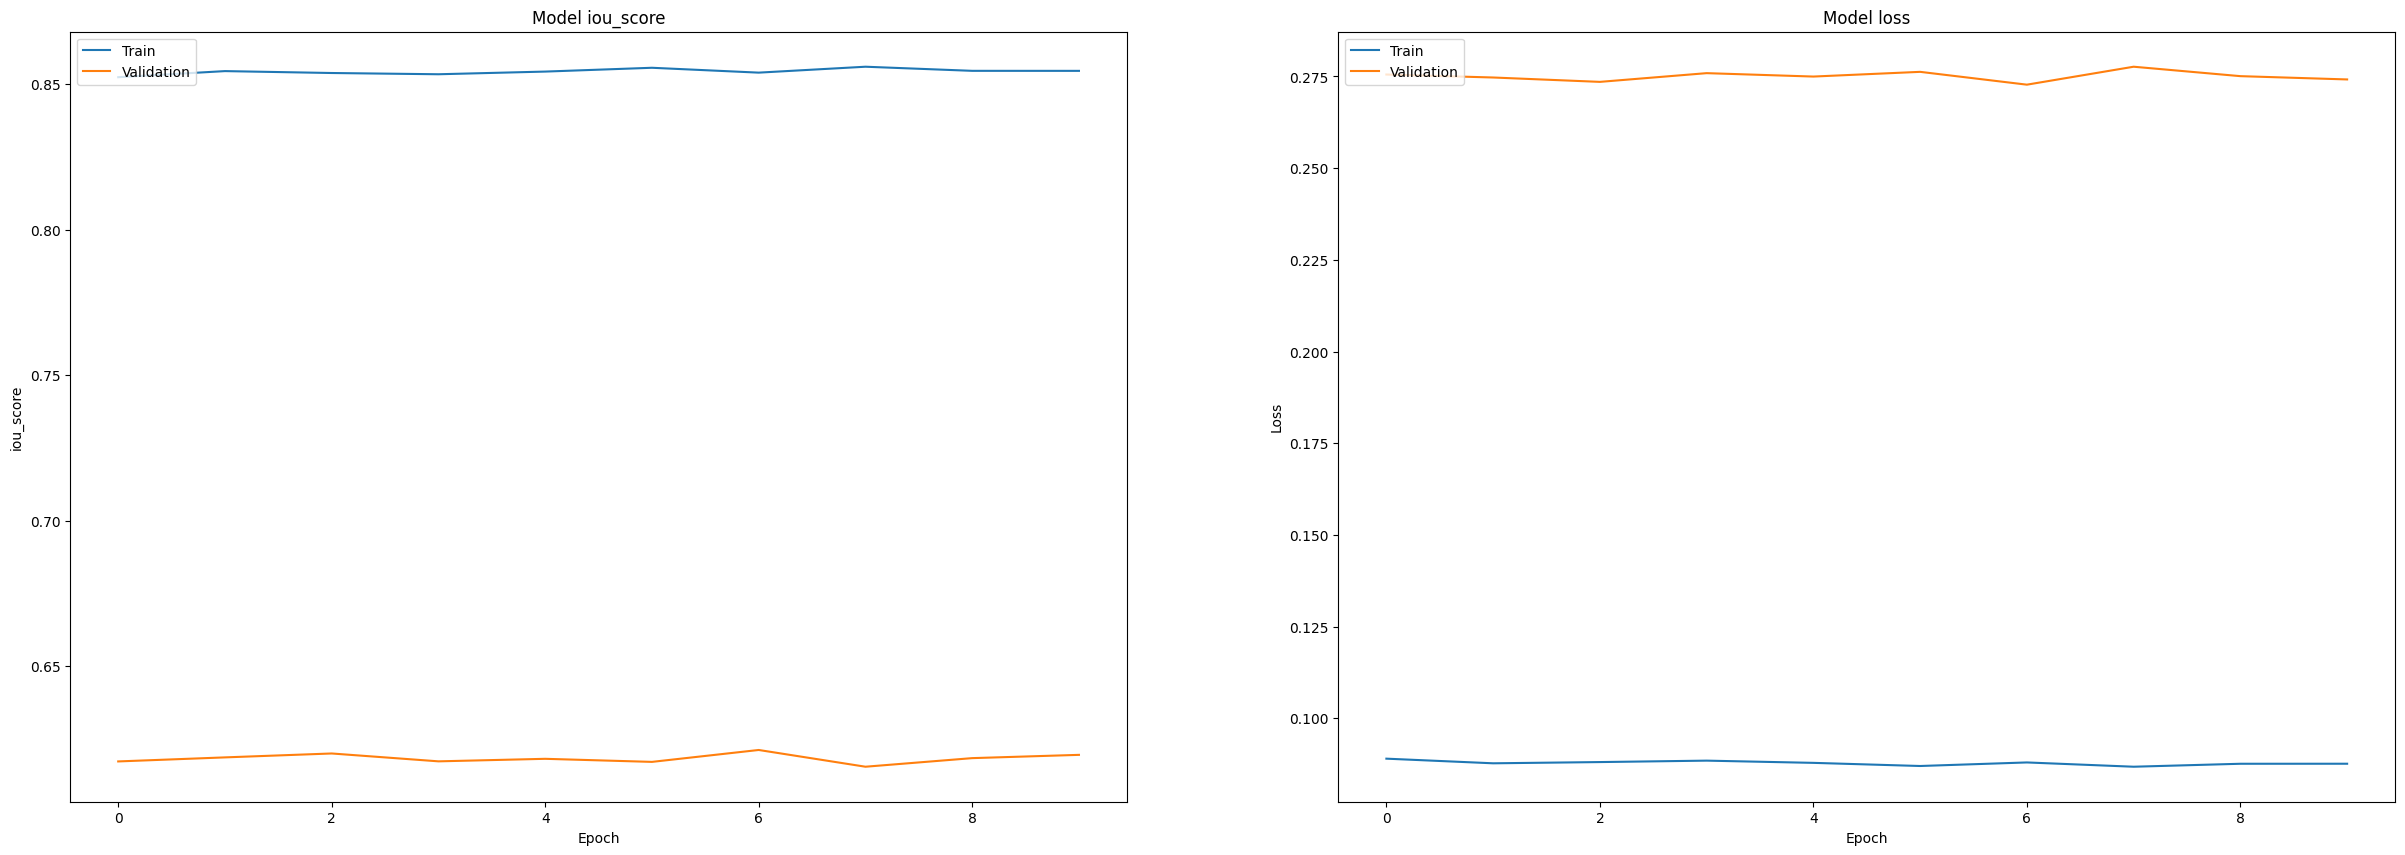

In [16]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
history = model.fit(
    x=train_dataloader.dataset.x,
    y=train_dataloader.dataset.y,
    shuffle=train_dataloader.shuffle,
    batch_size=train_dataloader.batch_size,
    callbacks=callbacks,
    epochs=10,
    validation_data=(valid_dataloader.dataset.x, valid_dataloader.dataset.y),
    )

Epoch 1/10
400/400 [==============================] - 107s 266ms/step - loss: 0.0890 - iou_score: 0.8523 - val_loss: 0.2755 - val_iou_score: 0.6173 - lr: 1.0000e-05
Epoch 2/10
400/400 [==============================] - 107s 267ms/step - loss: 0.0877 - iou_score: 0.8544 - val_loss: 0.2747 - val_iou_score: 0.6187 - lr: 1.0000e-05
Epoch 3/10
400/400 [==============================] - 106s 264ms/step - loss: 0.0881 - iou_score: 0.8538 - val_loss: 0.2735 - val_iou_score: 0.6200 - lr: 1.0000e-05
Epoch 4/10
400/400 [==============================] - 105s 264ms/step - loss: 0.0884 - iou_score: 0.8533 - val_loss: 0.2759 - val_iou_score: 0.6173 - lr: 1.0000e-05
Epoch 5/10
400/400 [==============================] - 108s 271ms/step - loss: 0.0878 - iou_score: 0.8542 - val_loss: 0.2750 - val_iou_score: 0.6182 - lr: 1.0000e-05
Epoch 6/10
400/400 [==============================] - 106s 266ms/step - loss: 0.0870 - iou_score: 0.8556 - val_loss: 0.2763 - val_iou_score: 0.6171 - lr: 1.0000e-05
Epoch 7/10